# Plot results

## Setup

In [2]:
# seaborn is not installed in notebook Docker image
! pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Using cached scipy-1.8.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.2 MB)


In [5]:
from os.path import join
import tempfile

import pandas as pd
import seaborn as sns

In [20]:
# This code was adapted from Raster Vision
# https://github.com/azavea/raster-vision/blob/master/rastervision_aws_s3/rastervision/aws_s3/s3_file_system.py
import os
from urllib.parse import urlparse

import boto3

s3 = boto3.client('s3')

def parse_uri(uri: str):
    """Parse bucket name and key from an S3 URI."""
    parsed_uri = urlparse(uri)
    bucket, key = parsed_uri.netloc, parsed_uri.path[1:]
    return bucket, key

def copy_to_s3(src_path: str, dst_uri: str) -> None:
    bucket, key = parse_uri(dst_uri)
    file_size = os.path.getsize(src_path)
    try:
        s3.upload_file(
            Filename=src_path,
            Bucket=bucket,
            Key=key)
    except Exception as e:
        raise NotWritableError(f'Could not write {dst_uri}') from e

In [21]:
out_root_uri = 's3://azavea-noaa-hydro-data/esip-experiments/plots/zarr/lf/07-14-2022a/'

# Read in results generated by benchmark_queries.ipynb.
results_uri = 's3://azavea-noaa-hydro-data/esip-experiments/benchmarks/zarr/lf/07-13-2022a.csv'
df = pd.read_csv(results_uri)
df

,Unnamed: 0,query,time_mean,time_std,nb_reaches,nb_days,nb_repeats,data_format,time_chunk_sz,feature_id_chunk_sz
0,0,mean_features_mean_day,24.486602,2.643130,1787,3652,5,zarr,672,30000
1,1,mean_day,35.422201,1.138170,1787,3652,5,zarr,672,30000
2,2,mean_week,19.809512,0.144222,1787,3652,5,zarr,672,30000
3,3,mean_features_mean_day,3.427545,0.248162,1787,365,5,zarr,672,30000
4,4,mean_day,4.312051,0.088990,1787,365,5,zarr,672,30000
5,5,mean_week,2.948410,0.294242,1787,365,5,zarr,672,30000
6,6,mean_features_mean_day,0.922876,0.070954,1787,31,5,zarr,672,30000
7,7,mean_day,1.137972,0.263506,1787,31,5,zarr,672,30000
8,8,mean_week,0.870396,0.082696,1787,31,5,zarr,672,30000
9,9,mean_features_mean_day,5.304696,0.288083,1787,3652,5,zarr,30000,672


In [22]:
# Add chunk_sz string column for convenience.
df['chunk_sz'] = [f'({x}, {y})' for x, y in zip(df.time_chunk_sz.values, df.feature_id_chunk_sz.values)]

# Add human readable column names for plotting purposes. It would be nice if we didn't have to do this, and could 
# just tell the plotting function how to translate column names.
df['chunk shape'] = df['chunk_sz']
df['run time: secs'] = df['time_mean']
df['days in query'] = df['nb_days']
df.head()

,Unnamed: 0,query,time_mean,time_std,nb_reaches,nb_days,nb_repeats,data_format,time_chunk_sz,feature_id_chunk_sz,chunk_sz,chunk shape,run time: secs,days in query
0,0,mean_features_mean_day,24.486602,2.643130,1787,3652,5,zarr,672,30000,"(672, 30000)","(672, 30000)",24.486602,3652
1,1,mean_day,35.422201,1.138170,1787,3652,5,zarr,672,30000,"(672, 30000)","(672, 30000)",35.422201,3652
2,2,mean_week,19.809512,0.144222,1787,3652,5,zarr,672,30000,"(672, 30000)","(672, 30000)",19.809512,3652
3,3,mean_features_mean_day,3.427545,0.248162,1787,365,5,zarr,672,30000,"(672, 30000)","(672, 30000)",3.427545,365
4,4,mean_day,4.312051,0.088990,1787,365,5,zarr,672,30000,"(672, 30000)","(672, 30000)",4.312051,365


## Plot using `seaborn`

### Make bar plot that is a visual dump of the whole dataframe.

Plotting concepts:
* things you can control in plot: x, y, hue, row, col, 
* independent vars: query, nb_days, chunk_sz
* (other independent vars we aren't varying yet): data_format, nb_reaches, nb_workers
* dependent vars: time_mean, time_std

Observations:
* The transposed chunk size (30000, 672) is much faster for large queries over 3652 days, but doesn't have much of an effect for smaller queries.
* The different queries all take roughly the same amount of time.

Text(0.5, 0.98, 'Timing streamflow queries using Zarr')

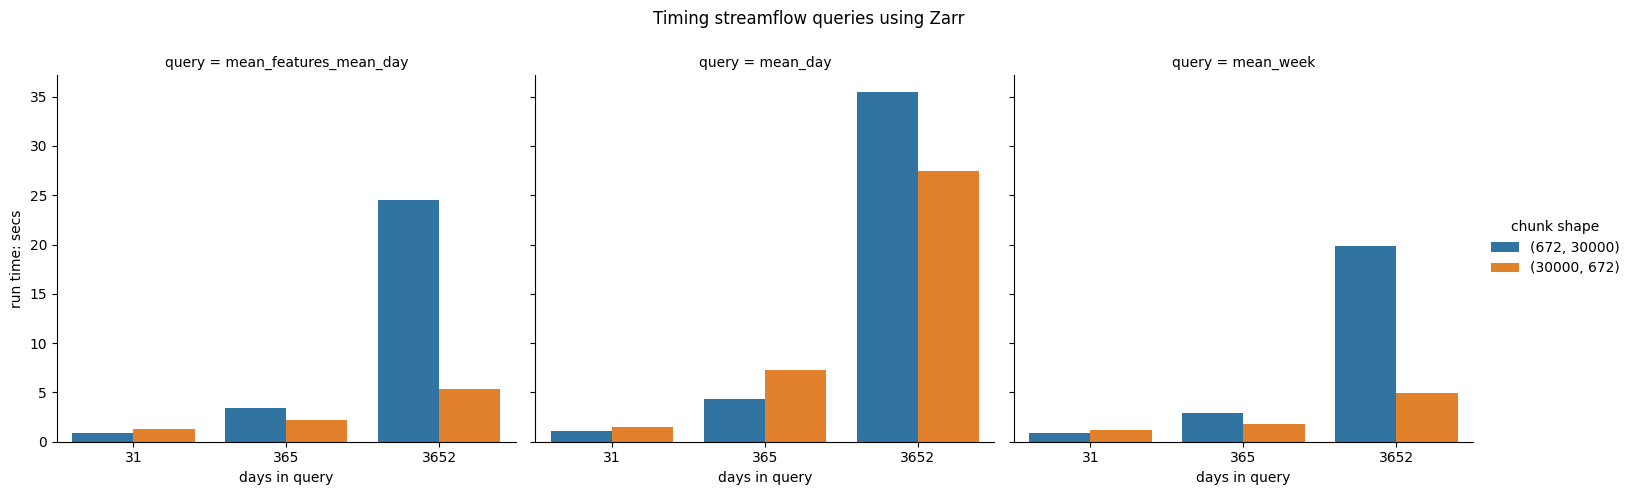

In [23]:
plot = sns.catplot(
    x='days in query', y='run time: secs', col='query', hue='chunk shape', 
    kind='bar', data=df)
fig = plot.fig
fig.subplots_adjust(top=0.85)
fig.suptitle('Timing streamflow queries using Zarr')

In [24]:
# Save plot to S3. 
plot_uri = join(out_root_uri, 'plot.png')
# All this rigmarole is needed because savefig only takes a string to a local path.
with tempfile.NamedTemporaryFile() as tf:
    fig.savefig(tf.name, format='png', dpi=100)
    copy_to_s3(tf.name, plot_uri)

## Plot using `pandas`

(This isn't as good as using seaborn, but is here just in case).

In [66]:
# This groups by chunk size over all experiments to see the effect of this indpendent variable.
_df = df.groupby('chunk_sz', as_index=False).mean()
_df

,chunk_sz,Unnamed: 0,time_mean,time_std,nb_reaches,nb_days,nb_repeats,time_chunk_sz,feature_id_chunk_sz
0,"(30000, 672)",13.0,5.87690,0.162814,1787.0,1349.333333,5.0,30000.0,672.0
1,"(672, 30000)",4.0,10.37084,0.552675,1787.0,1349.333333,5.0,672.0,30000.0


<AxesSubplot:xlabel='chunk_sz'>

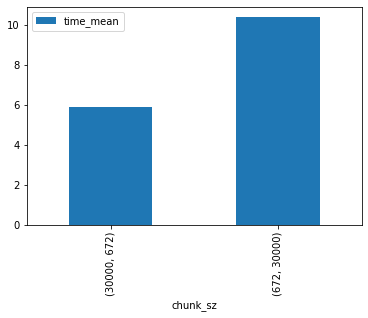

In [67]:
_df.plot('chunk_sz', 'time_mean', 'bar')